In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import glob

from gwtess import Gwtess, Gwtess_galaxy
%matplotlib inline

In [41]:
tesspath = '../data/tess-bandpass.csv'
spectrapath = glob.glob('../data/spectrum-at-*.csv')

galaxypath = '../data/spectrum-of-ngc4339.csv'

In [42]:
spectime = [0.49, 0.53, 1.46, 2.49, 3.46, 4.51, 7.45, 8.46]

nominalmerger = 1540
highmerger = 1540+3200
lowmerger = 1540-1220


GWT = Gwtess_galaxy(tesspath, spectrapath, spectime, mergerrate=nominalmerger)
eventAbsMag = GWT.get_obs_absmag()

# apmags, detected = GWT.sim_events(years=100)

# apmags_var, detected_var, is_onaxis = GWT.sim_events(fixedlum=False, years=100)
apmags_var, detected_var, is_onaxis = GWT.sim_events(fixedlum=False, years=100)

/Users/tom/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(array([   3.,   19.,   74.,  232.,  964.]),
 array([13, 14, 15, 16, 17, 18]),
 <a list of 5 Patch objects>)

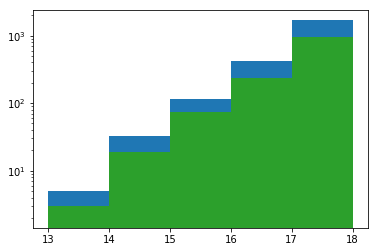

In [43]:
apmags_detected = apmags_var[detected_var]
is_onaxis_detected = is_onaxis[detected_var]

plt.hist(apmags_detected, alpha=1.0, bins=np.arange(13,19,1), log=True)
plt.hist(apmags_detected[~is_onaxis_detected], alpha=1.0, bins=np.arange(13,19,1), log=True)
plt.hist(apmags_detected[is_onaxis_detected], alpha=1.0, bins=np.arange(13,19,1), log=True)


In [44]:
print('total detections for variable brightness = {:.2f}'.format(
    apmags_detected.shape[0] * 0.041 / 1))
print('total on-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[is_onaxis_detected].shape[0] * 0.041 / 1))
print('total off-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[~is_onaxis_detected].shape[0] * 0.041 / 1))
# print('total detections for fixed brightness = {:.2f}'.format(
#     apmags_detected.shape[0] * 0.041 / 1))

total detections for variable brightness = 173.14
total on-axis detections for variable brightness = 98.52
total off-axis detections for variable brightness = 74.62


In [45]:
noff = GWT.distances[detected_var & ~is_onaxis].shape[0]
non = GWT.distances[detected_var & is_onaxis].shape[0]

a1 = np.sort(GWT.distances[detected_var & ~is_onaxis] / 1.E6)[int(np.round(noff*0.05, ))]
a2 = np.sort(GWT.distances[detected_var & ~is_onaxis] / 1.E6)[int(np.round(noff*0.95, ))]
print('off-axis distance range: {:.2f} - {:.2f}'.format(a1,a2))
       
a1 = np.sort(GWT.distances[detected_var & is_onaxis] / 1.E6)[int(np.round(non*0.05, ))]
a2 = np.sort(GWT.distances[detected_var & is_onaxis] / 1.E6)[int(np.round(non*0.95, ))]
print('on-axis distance range: {:.2f} - {:.2f}'.format(a1,a2))


print('{:.2f}% are with 200Mpc'.format(
    GWT.distances[detected_var & (GWT.distances < 200E6)].shape[0] /
      GWT.distances[detected_var].shape[0] * 100))

off-axis distance range: 55.55 - 231.28
on-axis distance range: 170.66 - 720.55
40.28% are with 200Mpc


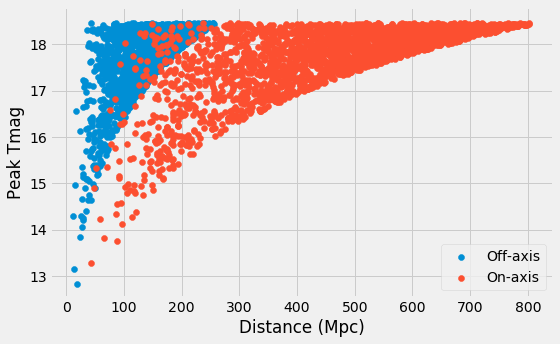

In [46]:
with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,5])
    plt.scatter(GWT.distances[detected_var & ~is_onaxis] / 1.E6, 
                apmags_var[detected_var & ~is_onaxis], label='Off-axis')
    plt.scatter(GWT.distances[detected_var & is_onaxis] / 1.E6, 
                apmags_var[detected_var & is_onaxis], label='On-axis')
#     plt.ylim(18.5,11.8)
#     plt.xlim(0,3.5)
    plt.ylabel('Peak Tmag')
    plt.xlabel('Distance (Mpc)')
    plt.legend()
    fig.tight_layout()
#     fig.savefig('events-per-decade.png')

In [49]:
x = (1.514E6 * 70 * 3600)
y = x * 10**(-0.4*11.3)
z = np.sqrt(y) / (x * 10**(-0.4*17.3))

t_sim = np.arange(0,10,1./48)
m_sim = GWT.get_apmag(GWT._f5(t_sim), GWT.obs_distance)

yerr_sim2 = np.sqrt(GWT.get_yerr_mag(m_sim, ) ** 2 + z**2)
erroradd2 = np.random.normal(scale=yerr_sim2[np.isfinite(yerr_sim2)], size=len(m_sim[np.isfinite(yerr_sim2)]))

yerr_sim = GWT.get_yerr_mag(m_sim, )
erroradd = np.random.normal(scale=yerr_sim[np.isfinite(yerr_sim)], size=len(m_sim[np.isfinite(yerr_sim)]))

NameError: name 'apmag' is not defined

In [ ]:
1.  / ((GWT.TESS_noise_1h(18.43) / 1.E6 / np.sqrt(6)) **2 + z**2)**0.5


In [48]:


with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,5])


    plt.errorbar(t_sim[np.isfinite(yerr_sim)],m_sim[np.isfinite(yerr_sim)]+erroradd, 
             yerr=yerr_sim[np.isfinite(yerr_sim)], fmt='.', lw=1,
                 label = 'Simulated TESS FFI light curve of GW20170817')
#     plt.errorbar(t_sim[np.isfinite(yerr_sim2)],m_sim[np.isfinite(yerr_sim2)]+erroradd2, 
#              yerr=yerr_sim2[np.isfinite(yerr_sim2)], fmt='.', lw=1,
#                  label = 'Simulated TESS FFI light curve of GW20170817')
    plt.ylim(19.9,16.9)
    plt.xlim(0,3.5)
    plt.xlabel('Time after T$_0$ (days)')
    plt.ylabel('TESS magnitude')
    plt.legend(loc=3)
    fig.tight_layout()

NameError: name 'yerr_sim' is not defined

(4000, 12000)

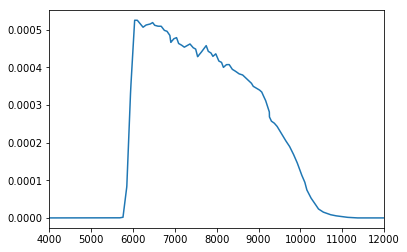

In [7]:
plt.plot(GWT.wavelength_ang,GWT.get_spectra_nu()[0])
# plt.plot(GWT.galaxy_ang, t.T[1] *1.E-3)

plt.xlim(4000,12000)
# plt.ylim(0,0.01)

In [106]:
plt.plot(GWT._f6(np.arange(4000,12000)))

AttributeError: 'Gwtess' object has no attribute '_f6'

In [ ]:
a = 6.59*900 * 10**(-0.4 * 11.3)
b = 6.59*900 * 10**(-0.4 * 17.3)
np.sqrt(a) / b

In [ ]:
-2.5* np.log10(251)

In [ ]:
GWT.TESS_noise_1h(11.3) /10**4

In [ ]:
# n = 4.403E11
x = 4.403E11 * 10**(-0.4 * 8) 
print(np.sqrt(x)/x)

In [ ]:
b = 18.3
np.sqrt(np.sqrt(4.403E11 * 10**(-0.4 * (b+6)) ) / (4.403E11 * 10**(-0.4 * b) ) )

In [ ]:
n = np.arange(9000,10000,1)
plt.plot(n, np.sqrt(n)/n)

In [117]:
x = (1.514E6 * 70 * 3600)
y = x * 10**(-0.4*11.3)
np.sqrt(y) / (x * 10**(-0.4*17.3))

In [19]:
GWT.get_absmag(11.3, GWT.obs_distance)

-21.763919283598678

array([ 16.57440314,  16.44291081,  16.25792765, ...,  17.74646148,
        18.36402714,  18.2827409 ])

In [19]:
np.where(np.random.normal(size=100)<1, )

(array([ 0,  1,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 18, 19, 20,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39,
        40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77,
        79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 98,
        99]),)

In [8]:
np.nonzero(is_onaxis == True)[0].shape[0] / is_onaxis.shape[0]

0.038950649350649354

In [20]:
is_onaxis[detected_var][is_onaxis[detected_var] == False].shape

(1790,)

In [36]:
apmags_var[detected_var].max()

18.452769779018251